# <b><span style="color:#845EC2"> Results and Analysis:</span></b> <b><span style="color:#D65DB1"> One word transcriptions</span></b>


<!-- <b><span style="color:#845EC2">845EC2</span></b>
<b><span style="color:#D65DB1">D65DB1</span></b>
<b><span style="color:#FF6F91">FF6F91</span></b>
<b><span style="color:#FF9671">FF9671</span></b>
<b><span style="color:#FFC75F">FFC75F</span></b>
<b><span style="color:#F9F871">F9F871</span></b>  -->

<!-- <b><span style="color:#d65db1"> ★ ★ ★ ★ </span></b>

<b><span style="color:#de7dc1"> ★ ★ ★ ★  </span></b>

<b><span style="color:#e69ed0"> ★ ★ ★ ★ </span></b>

<b><span style="color:#efbee0"> ★ ★ ★ ★</span></b> -->

Focus on <b><span style="color:#FF9671"> version 1 </span></b> in the first instance

### <b><span style="color:#b59eda"> Libary Imports </span>

In [2]:
# Library imports
import matplotlib.patches as mpatches
import self_made_functions as smf
import matplotlib.pyplot as plt
from   textwrap import wrap 
import seaborn as sns
import pandas as pd
import numpy as np
import jiwer
import os

### <b><span style="color:#e69ed0"> Data initialization  </span>

In [3]:
df_assessment, wv_path = smf.get_correct_df()

# Make a new directory for resaved files 
results_dir = './Transcriptions/Results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print(f"Directory {results_dir} created")

# Read empty transcriptions
empty_transcriptions = pd.read_csv('Transcriptions/empty_transcriptions_v1.csv')

# Transcription directory information
transcription_dir = './Transcriptions'
lst_csv = os.listdir(transcription_dir)
lst_csv = [file for file in lst_csv if file.startswith('tran') & file.endswith('v1.csv')] # The v1 transcribed files
# lst_csv = [file for file in lst_csv if file.startswith('true') & file.endswith('v1.csv')] # The v1 transcribed files

# Sort the list by model name
test_for_models = ['tiny', 'nb-whisper-tiny', 'nb-whisper-tiny-verbatim',
                    'base', 'nb-whisper-base', 'nb-whisper-base-verbatim',
                    'medium', 'nb-whisper-medium', 'nb-whisper-medium-verbatim']
lst_csv = sorted(lst_csv, key=lambda x: test_for_models.index(x.split('_')[-2]))

#### <b><span style="color:#e69ed0"> Save missing information </span></b>

 The transcription files are changed and re saved.

The <b><span style="color:#ff9671">empty-transcriptions</span></b> are added to the transcriptions.

The <b><span style="color:#ff9671">Phonetic Error Ratio (PER)</span></b> is calculated. 

A <b><span style="color:#ff9671">ID column</span></b> is added, and all the colum names are <b><span style="color:#ff9671">renamed</span></b> and organized.


A column for the <b><span style="color:#ff9671">model name</span></b> is also added. 

In [4]:
def resave_transcription_df(bool:True):
    lst_path = [os.path.join(transcription_dir, file) for file in lst_csv]

    # Iterate through the CSV files to add what is missing
    for path in lst_path:    
        # Read transcriped files
        df_csv = pd.read_csv(path)
        print(f"Reading {path}")
        if 'CER Output' in df_csv.columns:
            df_csv = df_csv.drop(['CER Output',"CER Score"], axis=1) # axis = 1 : drops column, = 0 : drops row 
        
        # Fix the CER column - For comparison
        df_csv['CER (Character Error Rate)'] = df_csv.apply(lambda x: jiwer.cer(x['Word'], x['Transcribed']), axis=1)
        
        # Add a column with the striped transcription and its corresponding CER.
        # This is interning regarding the performance of the verbatim model.
        # All transcriptions, excluding the empty transcriptions, are striped for all models, including verbatim.
        df_csv['transcribed_word_striped'] = df_csv['Transcribed'].apply(
            lambda x: x.strip().lower().replace(".", "").replace(",", "").replace("!", "").replace("?", "") 
            if isinstance(x, str) else x)      
        df_csv['striped_CER'] = df_csv.apply(lambda x: jiwer.cer(x['Word'], x['transcribed_word_striped']), axis=1)
        # print(df_csv[df_csv['File name']=='a01_sykkel.wav'])
        
        # Add model name
        model_name = path.split('_')[-2]
        df_csv["model_name"] = model_name
        
        # Change names
        df_csv = df_csv.rename(columns={"File name": "file_name",
                                    "CER (Character Error Rate)": "CER", # Character Error Rate (CER)
                                    "Word": "target_word", 
                                    "Transcribed": "transcribed_word", 
                                    "OG Score": "global_score"})
        
        for i, row in df_csv.iterrows():
            pron_lst = df_assessment[df_assessment['File name'] == row["file_name"]].pronScores.values[0].split(' ')
            pron_count = pron_lst.count('0')
            per = pron_count/len(pron_lst)
            df_csv.loc[i, "PER"] = per # Phonetic Error Rate (PER)
        
        df_csv = pd.concat([df_csv, empty_transcriptions[empty_transcriptions['model_name']==model_name]], ignore_index=True)
        df_csv = df_csv.reset_index(drop=True)
        # print(df_csv[df_csv['file_name']=='a01_sykkel.wav'])
        
        if len(df_csv.model_name.unique()) > 1:
            print(f"Error: {path} has more than one model name")
            break
        
        # Add ID column
        df_csv["id"] = df_csv["file_name"].apply(lambda x: x.split('_')[0])
        df_csv = df_csv.sort_values(by=['id'])
        
        # print(df_csv.columns)    
        # Reorder column names
        reorder_column = ["id", "global_score", 
                        "target_word", "PER", 
                        "transcribed_word", "CER", 
                        "transcribed_word_striped", "striped_CER",
                        "file_name", "model_name"]
        
        df_csv = df_csv[reorder_column]
        # print(df_csv.columns)   

        if bool:
            # Save the file
            csv_name = path.split('/')[-1]
            df_csv.to_csv(os.path.join(results_dir, csv_name), index=False)    

# resave_transcription_df(True)

### **<span style="color:#FF6F91"> BOX PLOT &nbsp;:&nbsp; </span>**
#### <span style="color:#ebaed8">  Every *model* compared &nbsp;:&nbsp; CER vs. PER for <b>Native</b>, <b>Non Native</b> and <b>All</b> </span>

Create directory to save the box plots &nbsp; : &nbsp; <span style="color:#ebaed8"> *./BoxPlots/Model_CER*</i></span>

In [5]:
save_dir_box_cer = './Transcriptions/Results/BoxPlots/Model_CER'
if not os.path.exists(save_dir_box_cer):
    os.makedirs(save_dir_box_cer)
    print(f"Directory {save_dir_box_cer} created")

Make a fuction that works for both all, native and non-native speakers

##### **<span style="color:#FF9671"> Giga Matrix**

In [6]:
# Could also use "lst_csv", but safer to remake the list
lst_csv_re_saved = os.listdir(results_dir)
lst_csv_re_saved = [file for file in lst_csv_re_saved if file.startswith('tran') & file.endswith('v1.csv')] 
lst_csv_re_saved = sorted(lst_csv_re_saved, key=lambda x: test_for_models.index(x.split('_')[-2]))
lst_path = [os.path.join(results_dir, file) for file in lst_csv_re_saved] 
ggm = pd.DataFrame()
# Iterate through the CSV files to add what is missing
for path in lst_path:
    # print(f"Reading {path}")
    df_csv = pd.read_csv(path)
    ggm = pd.concat([ggm, df_csv], ignore_index=True)
ggm = ggm.reset_index(drop=True)

##### **<span style="color:#FFC75F"> Fix model names for Giga Matrix**
Fix what the model names in the box plot shows, and that the PER can be one of the boxes in teh box plot.

In [7]:
def fix_model_names(gigamind:pd.DataFrame, cer_value:str = 'CER'):
    # Remove "whisper" from the model name
    gigamind['model_name'] = gigamind['model_name'].apply(lambda x: x.replace('nb-whisper', 'NNL'))

    # Get Capitalized model names fro tiny, base and medium
    gigamind['model_name'] = gigamind['model_name'].apply(lambda x: x.capitalize() if not x.startswith('NNL') or x.startswith('P') else x)

    # Add PER to model names so it gets its own column
    new_per = gigamind[gigamind.model_name == 'Tiny'][['PER', 'file_name', 'global_score']].copy()
    new_per = new_per.rename(columns={"PER": f"{cer_value}"})
    new_per['model_name'] = 'Phone Error Rate (PER)'

    gigamind = pd.concat([new_per, gigamind], ignore_index=True)
    return gigamind

##### **<span style="color:#F9F871"> BOX PLOT function for all models comparing PER and CER**

In [10]:
def box_plots_model(giga_df:pd.DataFrame, save_dir:str, title:str, cer_value:str = 'CER', cer_name:str = 'CER' , extended:int=2.1, max_verbatim:int = 1.5, save:bool = True):

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # ---------- Color palette  ---------- #
    palette = ['#FFC75F', # PER color
        '#A8BB5C', '#20887A', '#2F4858', # Model colors       
        '#A8BB5C', '#20887A', '#2F4858',          
        '#A8BB5C', '#20887A', '#2F4858'
        ]
    
    # ---------- Horizontal lines ---------- #
    # Line for the maximum cer_value for the medium-verbaitm
    max_cer_model1 = giga_df[(giga_df['model_name'] == 'NNL-medium-verbatim') & 
                            (giga_df[cer_value] >= 0) & 
                            (giga_df[cer_value] <= max_verbatim)][cer_value].max()
    ax.axhline(max_cer_model1, color='#B5AA99', linestyle='--')
    
    # Line for the median value
    median_value = giga_df[giga_df['model_name'] == 'Phone Error Rate (PER)'][cer_value].median()
    ax.axhline(median_value, color='#C1554D', linestyle='--')
    
    # Add to make space for the legend
    ax.axhline(extended, color='#ffffff', linestyle='--')
    
    #  ----------  Boxplot ---------- #
    sns.boxplot(x='model_name', y=cer_value, hue='model_name', data=giga_df, ax=ax, showfliers=False, palette=palette)

    #  ---------- Model legend box  ---------- #  (Custom legends found by ChatGPT) 
    chosen_colors = ['#A8BB5C', '#20887A', '#2F4858']
    chosen_names = ['OpenAI', 'Norwegian National Library (NNL)', 'NNL-Verbatim']
    legend_patches = [mpatches.Patch(color=color, label=name) for name, color in zip(chosen_names, chosen_colors)]

    # Add legend with custom settings
    # legend = ax.legend(handles=legend_patches, loc='upper right', frameon=True, shadow=True, title='Models')
    # legend.get_frame().set_facecolor('#f0eeeb')  # Background color
    # legend.get_title().set_fontsize('12')  # Title font size
    
    legend = ax.legend(handles=legend_patches, loc='upper right', frameon=False, shadow=False)
    for text in legend.get_texts():
        text.set_fontsize('11')  # Legend text font size
    
    #  ---------- Title and labels ---------- #
    plt.title(f'PER for the target words compared to the {cer_name} for the different models - {title}', fontsize=17)
    plt.xlabel('Target words  &  Model names', fontsize=14)
    plt.ylabel(f'PER & {cer_name}', fontsize=14)
    
    #  ---------- Wrap x-axis ---------- # (Wrap method found by ChatGPT) 
    model_names = [ '\n'.join(wrap(label, 14)) for label in giga_df['model_name'].unique() ]
    plt.xticks(ticks=range(len(model_names)), labels=model_names)
    plt.yticks(fontsize=13)
    
    # ------- Save or Show ---------- #
    plt.tight_layout()
    if save:
        plt.savefig(save_dir)
        plt.close()
    else: 
        plt.show()  

##### <b><span style="color:#D65DB1"> Box plot for all models, all data, native and non-native</span></b> NOT STRIPED (NS)

In [11]:
# ------------ All data Box Plot ------------ #
ggm_fix = fix_model_names(ggm)
box_plots_model(ggm_fix, os.path.join(save_dir_box_cer, 'PER_&_CER_All_Models_All_Data_NS.png'), 'Whole dataset')

# -------------- Non-Native Box Plot -------------- #
ggm_d = ggm[ggm['id'].str.contains('d')].copy()
ggm_fix_non_native = fix_model_names(ggm_d)
box_plots_model(ggm_fix_non_native, os.path.join(save_dir_box_cer, 'PER_&_CER_All_Models_Native_NS.png'), 
                            title='Native dataset', extended = 2.2, max_verbatim = 1)

# -------------- Non Native Box Plot -------------- #
ggm_a = ggm[ggm['id'].str.contains('a')].copy()
ggm_fix_native = fix_model_names(ggm_a)
box_plots_model(ggm_fix_native, os.path.join(save_dir_box_cer, 'PER_&_CER_All_Models_Non_Native_Data_NS.png'), 
                            title='Non Native dataset', extended = 2.05, max_verbatim = 1.6)

NameError: name 'box_plots_model' is not defined

##### <b><span style="color:#FF6F91"> Box plot for all models, all data, native and non-native</span></b> STRIPED (S)

In [135]:
# ------------ All data Box Plot ------------ #
ggm_fix_S = fix_model_names(ggm, cer_value='striped_CER')
box_plots_model(ggm_fix_S, os.path.join(save_dir_box_cer, 'PER_&_CER_All_Models_All_Data_S.png'), 
                            title = 'Whole dataset', cer_value = 'striped_CER', cer_name = 'Striped CER',
                            extended = 2, max_verbatim = 1.4)


# -------------- Native Box Plot -------------- #
ggm_d = ggm[ggm['id'].str.contains('d')].copy()
ggm_fix_native_S = fix_model_names(ggm_d, cer_value='striped_CER')
box_plots_model(ggm_fix_native_S, os.path.join(save_dir_box_cer, 'PER_&_CER_All_Models_Native_Data_S.png'), 
                            title='Native dataset', extended = 2.2, max_verbatim = 1,
                            cer_value = 'striped_CER', cer_name = 'striped CER')

# -------------- Non-Native Box Plot -------------- #
ggm_a = ggm[ggm['id'].str.contains('a')].copy()
ggm_fix_non_native_S = fix_model_names(ggm_a, cer_value='striped_CER')
box_plots_model(ggm_fix_non_native_S, os.path.join(save_dir_box_cer, 'PER_&_CER_All_Models_Non_Native_S.png'), 
                            title='Non Native dataset', extended = 2.1, max_verbatim = 1.6,
                            cer_value = 'striped_CER', cer_name = 'striped CER')

<b><span style="color:#845EC2">845EC2</span></b>
<b><span style="color:#D65DB1">D65DB1</span></b>
<b><span style="color:#FF6F91">FF6F91</span></b>
<b><span style="color:#FF9671">FF9671</span></b>
<b><span style="color:#FFC75F">FFC75F</span></b>
<b><span style="color:#F9F871">F9F871</span></b> 

#### <span style="color:#FFC75F">  Every **ID** compared for best model &nbsp;:&nbsp; CER vs. PER for <b>Native</b>, <b>Non Native</b> and <b>all</b> </span>
Create directory to save the box plots &nbsp; : &nbsp; <span style="color:#F9F871"> *./BoxPlots/Model_CER*</i></span>

##### **<span style="color:#FF6F91"> BOX PLOT function for all ID's comparing PER and CER** ➝ Only use the best model including **<span style="color:#FF6F91">Striped/Non Striped</span>**

In [103]:
def box_plots_id(best_model:pd.DataFrame, save_dir:str, cer:str = 'CER', cer_name:str = 'CER', save:bool = False):
    # ------ Melt model, so PER and CER can be compared ------ #
    df_melted = pd.melt(best_model, id_vars=['id'], value_vars=['PER', cer],
                        var_name='cer_type', value_name='cer_value') 
    df_melted_a = df_melted[df_melted['id'].str.contains('a')].copy() # Non Native
    df_melted_d = df_melted[df_melted['id'].str.contains('d')].copy() # Native 
    
    fig, ax = plt.subplots(1, 1, figsize=(25, 6))
    #  ----------  Boxplot ---------- #
    sns.boxplot(x='id', y='cer_value', hue='cer_type', data=df_melted_a, ax=ax, showfliers=False, palette=['#FFC75F', '#00966E'], linewidth=1.5)
    sns.boxplot(x='id', y='cer_value', hue='cer_type', data=df_melted_d, ax=ax, showfliers=False, palette=['#FFC75F', '#C1554D'], linewidth=1.5)
    
    #  ---------- Title and labels ---------- #
    plt.title(f"PER for target words compared to {cer_name} for the different ID's", fontsize=25)
    plt.xlabel("PER Target words &  CER ID's", fontsize=18)
    plt.ylabel(f'PER & {cer_name}', fontsize=18)
    
    #  ---------- x- and y-axis ---------- #
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=16)
    
    #  ---------- Model legend box  ---------- # 
    chosen_colors = ['#FFC75F', '#00966E', '#C1554D']
    chosen_names = ['PER', 'CER Non Native', 'CER Native']
    legend_patches = [mpatches.Patch(color=color, label=name) for name, color in zip(chosen_names, chosen_colors)]

    # Add legend with custom settings
    # legend = ax.legend(handles=legend_patches, loc='upper left', frameon=True, shadow=True)
    legend = ax.legend(handles=legend_patches, loc='upper left', frameon=False, shadow=False)
    legend.get_frame().set_facecolor('#f0eeeb')  # Background color
    # legend.get_title().set_fontsize('16')  # Title font size
    for text in legend.get_texts():
        text.set_fontsize('16')  # Legend text font size
    
    
    #  ---------- Save or Show ---------- #
    plt.tight_layout()
    if save:
        plt.savefig(save_dir)
        plt.close()
    else:
        plt.show()
# -------- BEST MODEL -------- #
model_path = './Transcriptions/Results/transcriptions_nb-whisper-medium-verbatim_v1.csv'
df_best = pd.read_csv(model_path)


##### <b><span style="color:#ffdb9f"> Box plot for all id's and all data</span></b> NOT STRIPED (NS)

In [109]:
box_plots_id(df_best, os.path.join(save_dir_box_cer, 'PER_&_CER_All_IDs_NS.png'), cer='CER', cer_name='CER', save=True)

##### <b><span style="color:#ff9ab2"> Box plot for all id's and all data</span></b> STRIPED (S)

In [97]:
box_plots_id(df_best, os.path.join(save_dir_box_cer, 'PER_&_CER_All_IDs_S.png'), cer='striped_CER', cer_name='striped CER', save=True)

### **<span style="color:#D65DB1"> BOX PLOT for scores gruped and CER / PER </span>** ➝ Only use the best model


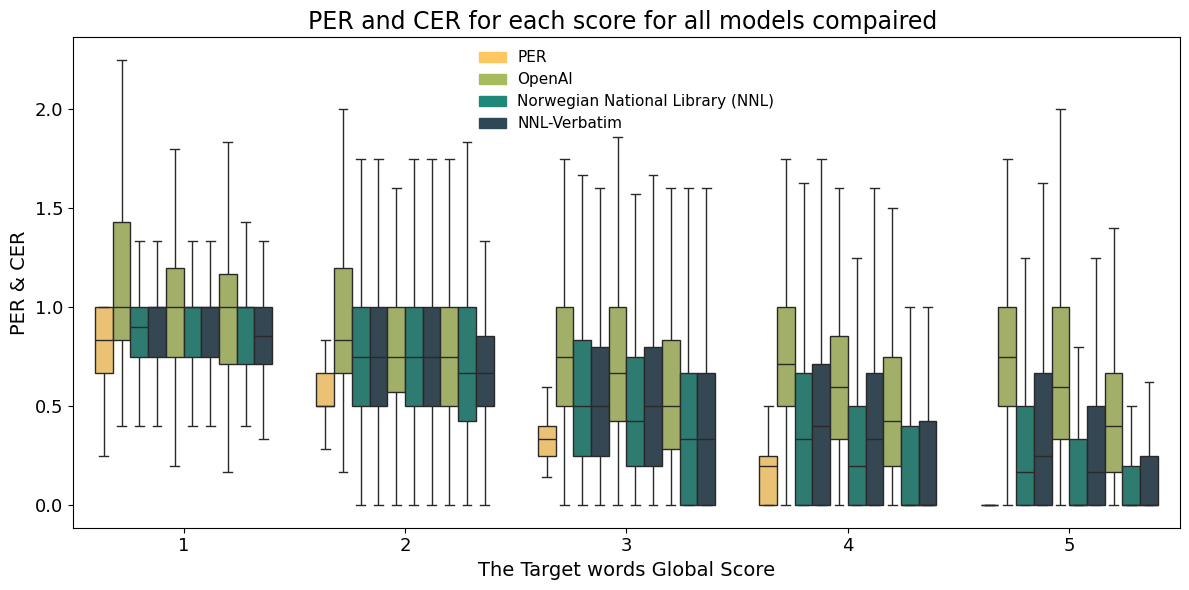

In [ ]:
ggm_fix = fix_model_names(ggm)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# ---------- Color palette  ---------- #
palette = ['#FFC75F', # PER color
            '#A8BB5C', '#20887A', '#2F4858', # Model colors       
            '#A8BB5C', '#20887A', '#2F4858',          
            '#A8BB5C', '#20887A', '#2F4858']

#  ----------  Boxplot ---------- #
sns.boxplot(x='global_score', y='CER', hue='model_name', data=ggm_fix, ax=ax, showfliers=False, palette=palette)

#  ---------- Model legend box  ---------- #  (Custom legends found by ChatGPT) 
chosen_colors = ['#FFC75F', '#A8BB5C', '#20887A', '#2F4858']
chosen_names = ['PER', 'OpenAI', 'Norwegian National Library (NNL)', 'NNL-Verbatim']
legend_patches = [mpatches.Patch(color=color, label=name) for name, color in zip(chosen_names, chosen_colors)]


legend = ax.legend(handles=legend_patches, loc='best', frameon=False, shadow=False, ncol = 2)
for text in legend.get_texts():
    text.set_fontsize('11')  # Legend text font size

#  ---------- Title and labels ---------- #
plt.title(f'PER and CER for each score for all models compaired ', fontsize=17)
plt.xlabel('The Target words Global Score', fontsize=14)
plt.ylabel(f'PER & CER', fontsize=14)

#  ---------- Wrap x-axis ---------- # (Wrap method found by ChatGPT) 
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# ------- Save or Show ---------- #
plt.tight_layout()
plt.show()
# if save:
#     plt.savefig(save_dir)
#     plt.close()
# else: 
#     plt.show()  